In [6]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

import scipy.io
import numpy as np
import h5py

import EMGfilter
import NeorecFiltering
import PNinterpolate

import time,tqdm

srate = 512

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]


def imagesc(x):
    plt.imshow(x,extent = [0,1,0,1])

In [7]:
datafile = 'data/fingers_400s_09-28_17-55-49/experiment_data.h5'
#datafile = 'data/6_right_thumb_60s_09-28_17-47-02/experiment_data.h5'

In [8]:
with h5py.File(datafile,'r+') as f1:
    print(list(f1.keys()))
    print(list(f1['protocol1'].keys()))

['channels', 'fs', 'protocol0', 'protocol1', 'settings.xml', 'stream_info.xml']
['mark_data', 'par_data', 'posx_data', 'posy_data', 'raw_data', 'raw_other_data', 'reward_data', 'signals_data', 'signals_stats', 'state_data', 'timestamp_data']


In [9]:
with h5py.File(datafile,'r+') as f1:
    list(f1.keys())[0]
    
    raw_data = np.array(f1['protocol1']['raw_data'])

    posx_data_full = np.array(f1['protocol1']['posx_data'])
    posy_data_full = np.array(f1['protocol1']['posy_data'])

    state_data = np.array(f1['protocol1']['state_data'])
    par_data = np.array(f1['protocol1']['par_data'])

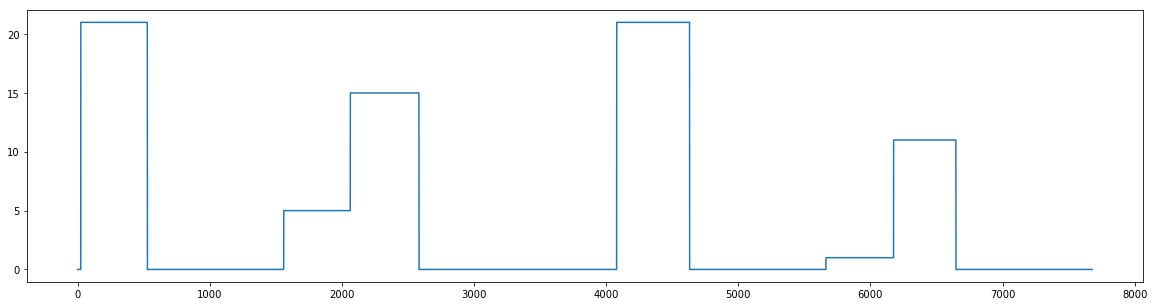

In [10]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(state_data[srate*10:srate*25])

In [11]:
#plt.rcParams['figure.figsize'] = [20, 20]

#imagesc(raw_data)

In [12]:
#raw_data[np.isnan(raw_data)] = 0

#plt.rcParams['figure.figsize'] = [20, 20]

#imagesc(raw_data)

In [13]:
raw_data.shape

(208400, 309)

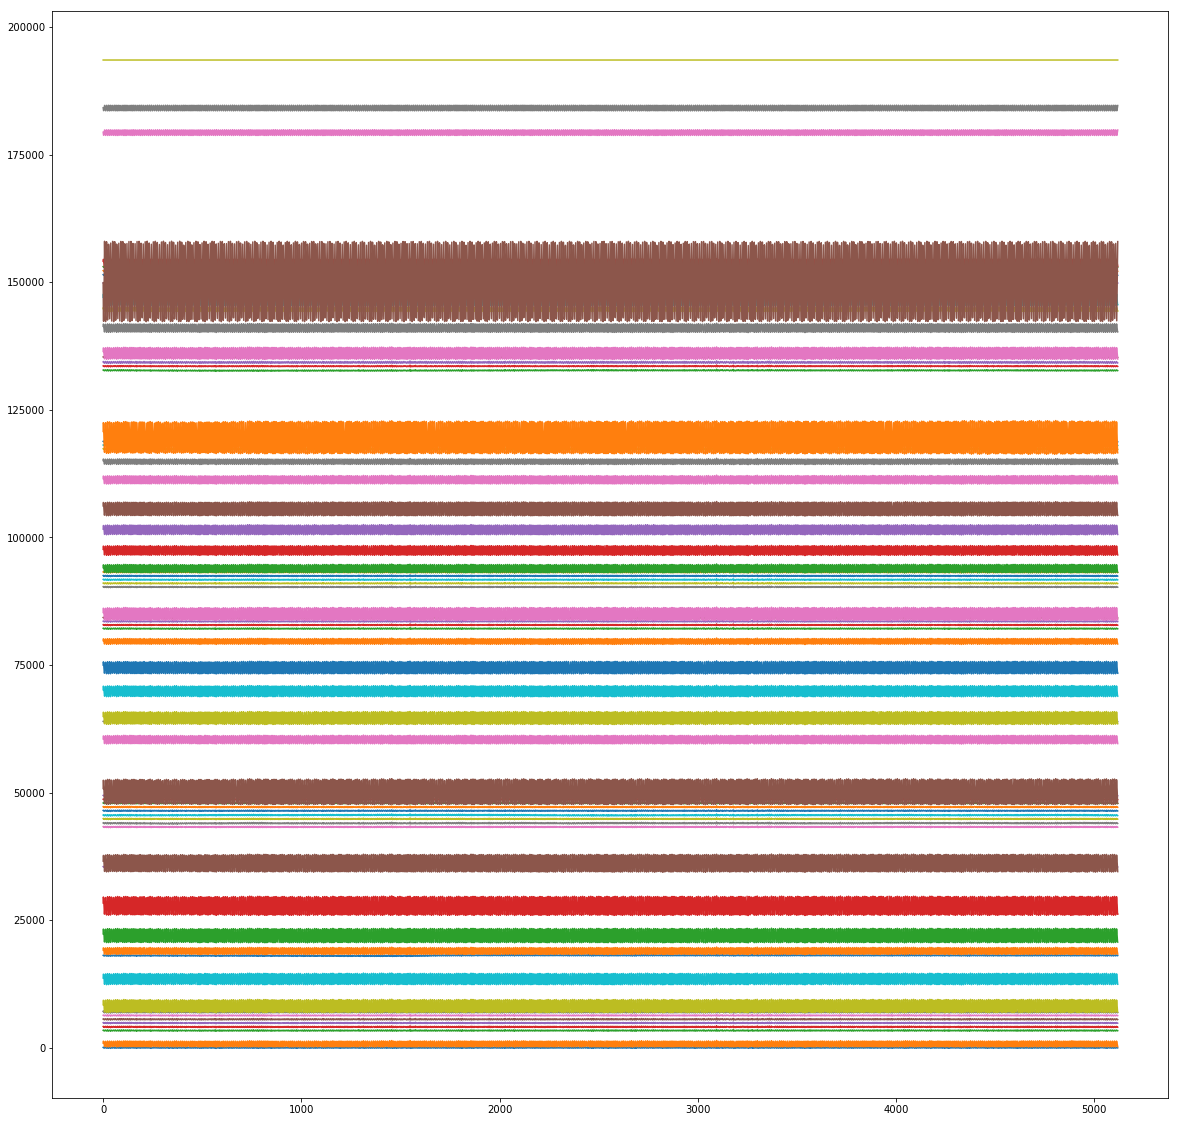

In [14]:
k = 0

sec_to_plot = 100

plt.rcParams['figure.figsize'] = [20, 20]

for i in np.arange(0,69):
    plt.plot(raw_data[:srate*10,i] + k)
    k = k + 2*(np.max(raw_data[:srate*10,i]) - np.min(raw_data[:srate*10,i]))
    

In [15]:
#seq = 16
#num_ch_in_354 = np.arange(6*seq,6*seq+6)

#self.neuron_idxs = np.hstack((np.arange(16,36),np.arange(39,59)))
#self.ch_idxs = np.hstack((np.arange(96,216),np.arange(234,354)))



In [16]:
idxs

NameError: name 'idxs' is not defined

Hand:


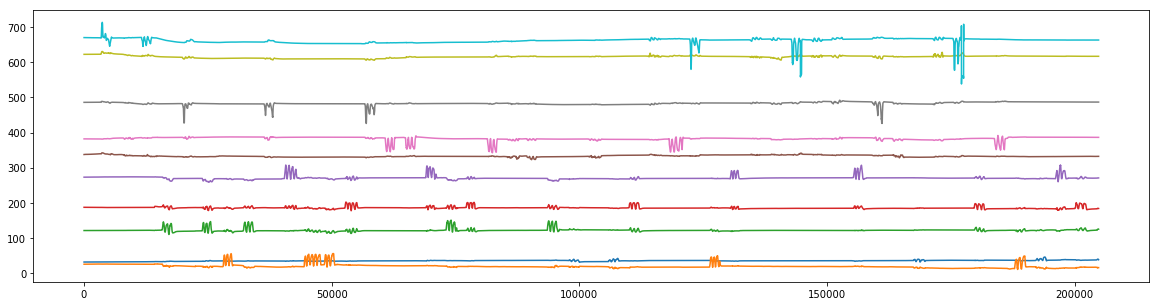

In [24]:
k = 0

sec_to_plot = 400

plt.rcParams['figure.figsize'] = [20, 5]

ch_start_pn = 69

#idxs = np.array([78,80,84,86,104,140,141])
#idxs = idxs - 68
#print(idxs)

idxs = np.array([11, 41, 59, 83, 107, 131, 161, 179, 203, 227]) + ch_start_pn

print("Hand:")

# FOUND: [3,4,5] = LEFT HAND

#for i in [72,73,74,78,80,84,86,104,140]:#,160]:
for i in idxs:
    pndata = PNinterpolate.interpolatePN(raw_data[:srate*sec_to_plot,i])
    plt.plot(pndata + k)
    k = k + 2*(np.max(pndata) - np.min(pndata))
    

In [54]:
#workdir='data\\6_right_thumb_60s_09-28_17-47-02\\'
#workdir='data\\7_right_index_60s_09-28_17-48-27\\'
#workdir='data\\8_right_middle_60s_09-28_17-50-08\\'
#workdir='data\\9_right_ring_60s_09-28_17-51-35\\'
#workdir='data\\10_right_little_60s_09-28_17-52-54\\'

workdir='data\\fingers_400s_09-28_17-55-49\\'


datafile='experiment_data.h5'


lag = 2
forward = 0;
downsample_coef=0

MyoOffsetCh=64
numCh=64

num_aux = 5
offset_ch = 0

NtrainStart=10000
NtrainEnd=70000

NtestStart=70000
NtestEnd=140000

#%%
myo_range=range(0,MyoOffsetCh)
wristrange=[11, 11, 11]
fingersrange=[11, 41, 59, 83, 107, 131, 161, 179, 203, 227]

#wristrange=[]
#fingersrange=[72,73,74,78,80,84,86,104,140]
fingersrange=[f+len(myo_range)+num_aux+offset_ch for f in fingersrange]

wristrange=[w+len(myo_range)+num_aux+offset_ch for w in wristrange]
#fingersrange=[f+len(myo_range)+num_aux+offset_ch for f in fingersrange]

def offset(data,lag,leftOffset,rightOffset=0):
    return data[leftOffset+lag:data.shape[0]-rightOffset]

def preprocessMyoData(data):
    data=data[:,:numCh]
    data=NeorecFiltering.CommonAverage(data)
    data=EMGfilter.filterEMG(data)
    return data

def preprocessPnData(wrist, fingers):
    wrist=PNinterpolate.interpolatePN(wrist)
    fingers=PNinterpolate.interpolatePN(fingers)

    #because PN coords order isnt natural
    x_ind=wrist[:,1];
    y_ind=wrist[:,0];
    z_ind=wrist[:,2];
    #stack with angles
    coords=np.vstack((x_ind,y_ind,z_ind)).T
    coords=np.hstack((coords,fingers))
    return coords

def prepareEmgDataWithHistory(data):
    data=preprocessMyoData(data)
    print(data.shape)
    emg_lag=np.empty((data.shape[0]-2-lag-forward,numCh*(lag+1)))
    for l in range(lag+1):
        emg_lag[:,l*numCh:(l+1)*numCh]=data[(2+l):(data.shape[0]-lag-forward+l),:]
    data=emg_lag
    data=np.hstack((np.ones((data.shape[0],1)),data))
    return data
    
def getTrainData():
    global raw_data

    with h5py.File(workdir+datafile,'r+') as f1:
        raw_data = np.array(f1['protocol1']['raw_data'])
        pnwrist=raw_data[NtrainStart:NtrainEnd,wristrange]
        pnfingers=raw_data[NtrainStart:NtrainEnd,fingersrange]
        myo=raw_data[NtrainStart:NtrainEnd,myo_range]
        return myo, pnwrist, pnfingers
    
def getTestData():

    global raw_data
    pnwrist=raw_data[NtestStart:NtestEnd,wristrange]
    pnfingers=raw_data[NtestStart:NtestEnd,fingersrange]
    myo=raw_data[NtestStart:NtestEnd,myo_range]
    return myo, pnwrist, pnfingers
    
    
#%% Fetching train data
    
raw_data=[]

myo, pnwrist, pnfingers=getTrainData()

myo=prepareEmgDataWithHistory(myo)

Coord=preprocessPnData(pnwrist,pnfingers)

Vel=np.apply_along_axis(np.diff,0,Coord)

Acc=np.apply_along_axis(np.diff,0,Vel)    

#%% Decoding

Coords=np.hstack((np.apply_along_axis(offset,0,Coord,lag,2),np.apply_along_axis(offset,0,Vel,lag,1),np.apply_along_axis(offset,0,Acc,lag,0)))

#Wiener
W = np.linalg.pinv(myo) 
W = W @ Coords

Measurement_Error=Coords-myo @ W;
Measurement_Error_Covar=np.cov(Measurement_Error.T);
W=W.T;

#Kalman
Now=np.hstack((np.apply_along_axis(offset,0,Coord,lag,3),np.apply_along_axis(offset,0,Vel,lag,2),np.apply_along_axis(offset,0,Acc,lag,1)))
#Now=np.apply_along_axis(offset,0,Coord,lag,3)

Lag=np.hstack((np.apply_along_axis(offset,0,Coord,lag,2,1),np.apply_along_axis(offset,0,Vel,lag,1,1),np.apply_along_axis(offset,0,Acc,lag,0,1)))
#Lag=np.apply_along_axis(offset,0,Coord,lag,2,1)

A=np.linalg.pinv(Lag) @ Now

State_Trans_Error=Now-Lag @ A
State_Trans_Covar=np.cov(State_Trans_Error.T)

A=A.T

Ex = State_Trans_Covar; # process noise
Ez = Measurement_Error_Covar;  # measurement noise

scipy.io.savemat(workdir+'filterParams.mat', mdict={'W': W, 'A':A, 'Ex': Ex, 'Ez':Ez})

#%% Fetching test data


myo, pnwrist, pnfingers=getTestData()

myo=prepareEmgDataWithHistory(myo)

Coord=preprocessPnData(pnwrist,pnfingers)

#Vel=np.apply_along_axis(np.diff,0,Coord)
#
#Acc=np.apply_along_axis(np.diff,0,Vel) 

#%% decoding

Start = np.zeros((1,Coords.shape[1]))
predic_var = np.empty((0,Coords.shape[1]));
Kalman_estimate = np.copy(Start.T);
P_after = np.copy(Ex);
Coordinates_Estimate=np.copy(Start.T)
Wiener_Estimate=np.copy(Start.T)

WienerCoords=np.empty((myo.shape[0],Coords.shape[1]))
KalmanCoords=np.empty((myo.shape[0],Coords.shape[1]))



timepassed=time.time()

for t in tqdm.tqdm(range(myo.shape[0])):
    #Predict coordinate by state measurement equation
    X_measurement_estimate=W @ myo[t,:][:,None];
    #Store Wiener Estimate
    WienerCoords[t,:]=X_measurement_estimate.T;
    
    #Kalman
    X_state_estimate = A @ Kalman_estimate
    P_before = A @ P_after @ A.T + Ex
    P_after=np.linalg.pinv(np.linalg.pinv(P_before)+np.linalg.pinv(Ez))
    Kalman_estimate=P_after @ (np.linalg.pinv(P_before) @ X_state_estimate+np.linalg.pinv(Ez) @ X_measurement_estimate)
        
    KalmanCoords[t,:] = Kalman_estimate.T
    
timepassed=time.time()-timepassed
print(timepassed)

#%% Parsing results

Kc=KalmanCoords[:,:Coord.shape[1]]
Tc=Coord[lag+2:,:]

from matplotlib import pyplot as plt

KalmanStabilize=round(0.03*Kc.shape[0])

plt.figure()
k = 0
for i in range(Kc.shape[1]):
    plt.subplot(Kc.shape[1],1,i)
    plt.plot(Kc[KalmanStabilize:,i])
    plt.plot(Tc[KalmanStabilize:,i])

    
for i in range(Kc.shape[1]):
    print(np.corrcoef(Kc[KalmanStabilize:,i].T,Tc[KalmanStabilize:,i].T)[0,1])
    

(60000, 64)
(70000, 64)


100%|███████████████████████████████████| 69996/69996 [02:21<00:00, 495.52it/s]


141.26340103149414


ValueError: num must be 1 <= num <= 13, not 0

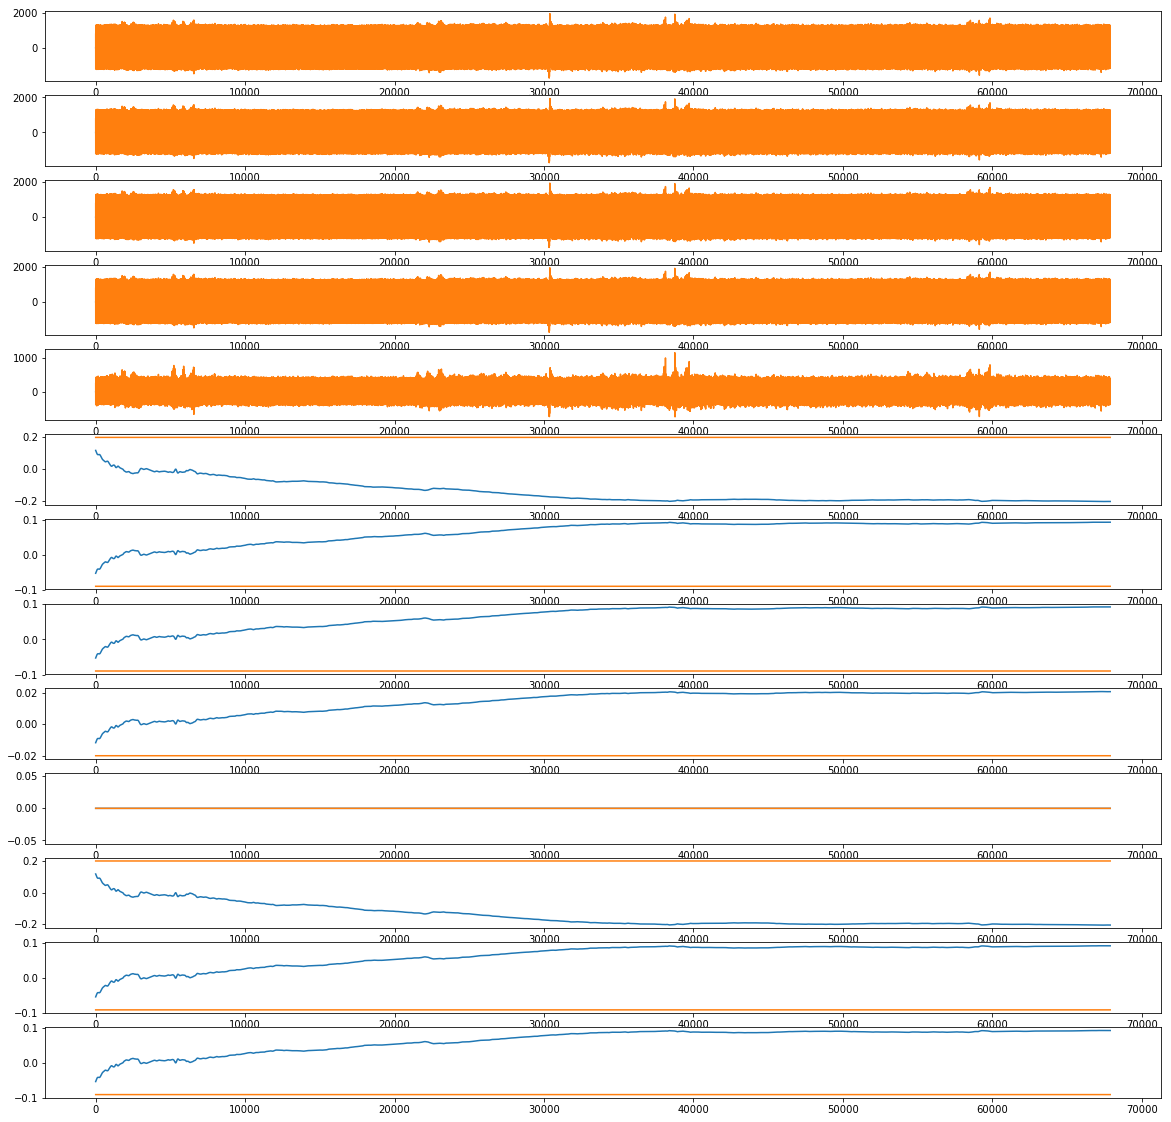

In [52]:
plt.figure()
k = 1

plt.rcParams['figure.figsize'] = [20, 20]

for i in range(Kc.shape[1]):
    plt.subplot(Kc.shape[1],1,k)
    plt.plot(Kc[KalmanStabilize:,i])
    plt.plot(Tc[KalmanStabilize:,i])
    #plt.ylim([-0,50])
    k = k + 1



In [53]:
    
for i in range(Kc.shape[1]):
    print(np.corrcoef(Kc[KalmanStabilize:,i].T,Tc[KalmanStabilize:,i].T)[0,1])
    

IndentationError: expected an indented block (<ipython-input-53-f012eeb6aba6>, line 3)

-0.195992842217
-0.11357858827
0.56825514301
-0.10996293825
-0.23656491626
-0.11088641569
-0.227523176912
0.65008503345


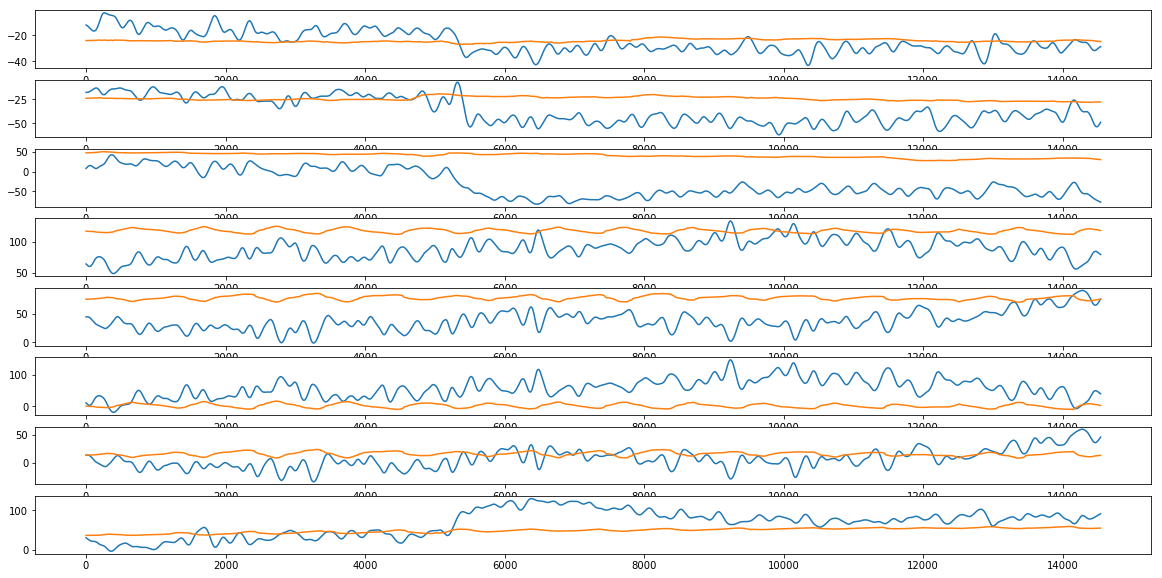

In [20]:
plt.figure()
for i in range(Kc.shape[1]):
    plt.subplot(Kc.shape[1]*100+11+i)
    plt.plot(Kc[KalmanStabilize:,i])
    plt.plot(2*Tc[KalmanStabilize:,i])


for i in range(Kc.shape[1]):
    print(np.corrcoef(Kc[KalmanStabilize:,i].T,Tc[KalmanStabilize:,i].T)[0,1])